In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import convolve2d

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


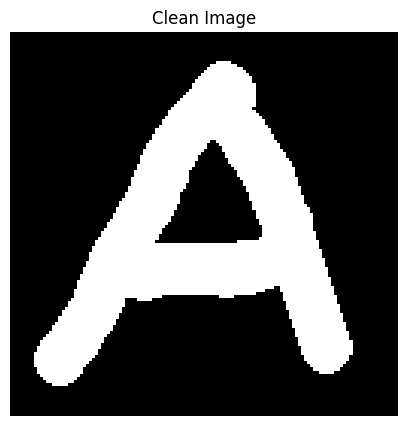

In [19]:
img = pd.read_csv('/content/drive/MyDrive/Chalmers/SSY316/Assignment4/letterA.csv').to_numpy()

plt.figure(figsize=(5,5))
plt.title('Clean Image')
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
plt.axis('off')
plt.show()

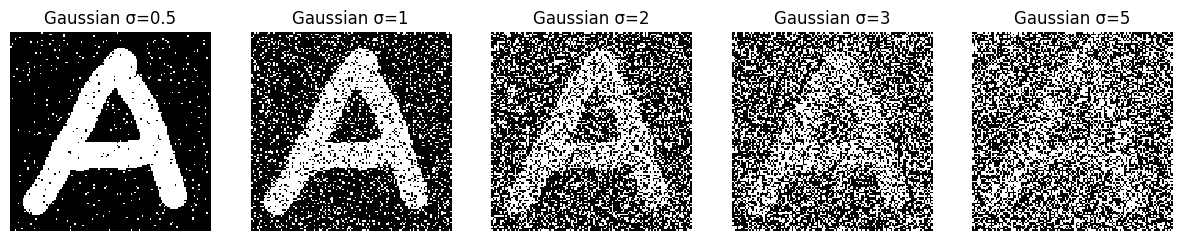

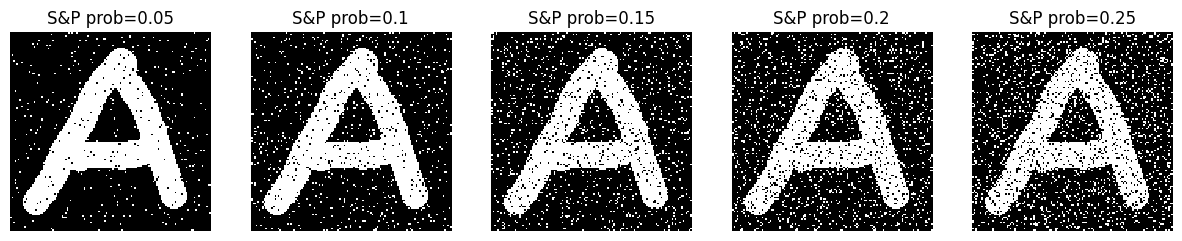

In [20]:
# Q1

def add_gaussian_noise(image, sigma):
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    noisy_image = np.where(noisy_image >= 0, 1, -1)
    return noisy_image

def add_salt_and_pepper_noise(image, prob):
    noisy_image = image.copy()
    rnd = np.random.rand(*image.shape)
    noisy_image[rnd < (prob / 2)] = 1
    noisy_image[rnd > 1 - (prob / 2)] = -1
    return noisy_image

# Define noise levels
gaussian_sigmas = [0.5, 1, 2, 3, 5]

plt.figure(figsize=(15,3))
for i, sigma in enumerate(gaussian_sigmas):
    noisy_img = add_gaussian_noise(img, sigma)
    plt.subplot(1, len(gaussian_sigmas), i+1)
    plt.imshow(noisy_img, cmap='gray', interpolation='nearest')
    plt.title(f'Gaussian σ={sigma}')
    plt.axis('off')
plt.show()

# Define noise levels
sap_probs = [0.05, 0.1, 0.15, 0.2, 0.25]

plt.figure(figsize=(15,5))
for i, prob in enumerate(sap_probs):
    noisy_img = add_salt_and_pepper_noise(img, prob)
    plt.subplot(1, len(sap_probs), i+1)
    plt.imshow(noisy_img, cmap='gray', interpolation='nearest')
    plt.title(f'S&P prob={prob}')
    plt.axis('off')
plt.show()

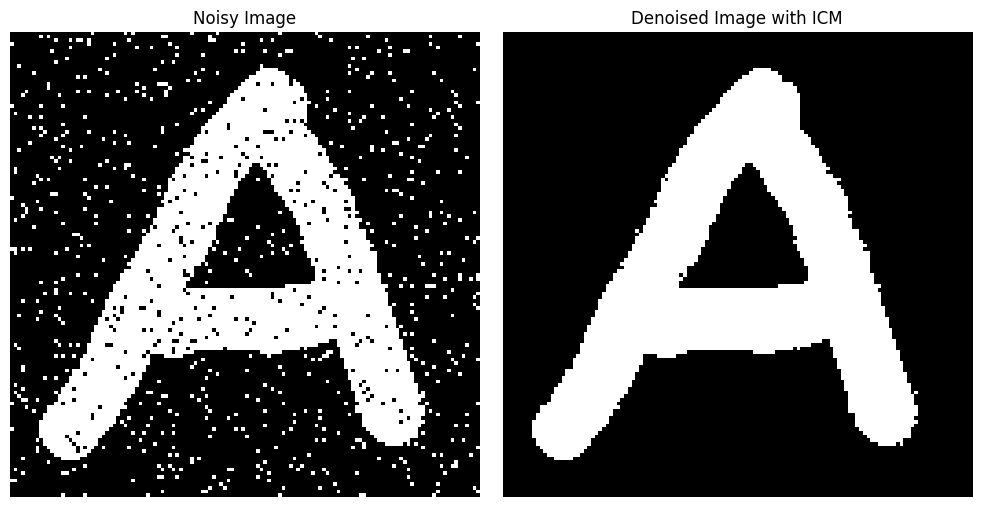

In [21]:
# Q2

def icm_denoise(y, h, beta, eta, max_iter=50, tol=1e-5):
    x = y.copy()
    H, W = x.shape

    # Define the convolution kernel for 4-connected neighbors
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    energies = []

    for it in range(max_iter):
        x_old = x.copy()

        # Compute the sum of neighbors for each pixel
        neighbors_sum = convolve2d(x, kernel, mode='same', boundary='wrap')

        # Compute the conditional energy for x_j = +1 and x_j = -1
        energy_plus = h * 1 - beta * neighbors_sum - eta * y
        energy_minus = h * (-1) + beta * neighbors_sum + eta * y

        # Update x based on the lower energy
        x = np.where(energy_plus < energy_minus, 1, -1)

        # Compute the total energy
        total_energy = h * np.sum(x) - beta * np.sum(x * neighbors_sum) - eta * np.sum(x * y)
        energies.append(total_energy)

        # Check for convergence
        changes = np.sum(x != x_old)
        #print(f"Iteration {it+1}: Energy={total_energy}, Changes={changes}")
        if changes == 0:
            print("Convergence achieved.")
            break

    return x, energies

# Define parameters of the energy function
h = 0.5
beta = 1.0
eta = 1.0

noisy_img = add_salt_and_pepper_noise(img, 0.10)

# Apply ICM denoising
denoised_img, energies = icm_denoise(noisy_img, h, beta, eta, max_iter=50)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(noisy_img, cmap='gray', interpolation='nearest')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_img, cmap='gray', interpolation='nearest')
plt.title('Denoised Image with ICM')
plt.axis('off')

plt.tight_layout()
plt.show()

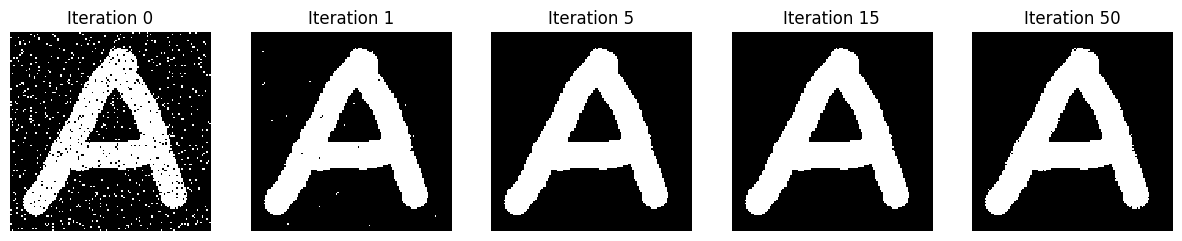

In [22]:
# Q3

def icm_denoise_with_snapshots(y, h, beta, eta, snapshot_iters=[0,1,5,15,50], max_iter=50):
    x = y.copy()
    H, W = x.shape
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    energies = []
    snapshots = {0: x.copy()}

    for it in range(1, max_iter+1):
        x_old = x.copy()
        neighbors_sum = convolve2d(x, kernel, mode='same', boundary='wrap')
        energy_plus = h * 1 - beta * neighbors_sum - eta * y
        energy_minus = h * (-1) + beta * neighbors_sum + eta * y
        x = np.where(energy_plus < energy_minus, 1, -1)
        total_energy = h * np.sum(x) - beta * np.sum(x * neighbors_sum) - eta * np.sum(x * y)
        energies.append(total_energy)
        changes = np.sum(x != x_old)
        #print(f"Iteration {it}: Energy={total_energy}, Changes={changes}")
        if it in snapshot_iters:
            snapshots[it] = x.copy()
        if changes == 0:
            print("Convergence achieved.")
            break
    return x, energies, snapshots

# Define parameters of the energy function
h = 0.5
beta = 1.0
eta = 1.0

noisy_img = add_salt_and_pepper_noise(img, 0.10)

# Define snapshot iterations
snapshot_iters = [0, 1, 5, 15, 50]

# Apply ICM denoising with snapshots
denoised_img_final, energies, snapshots = icm_denoise_with_snapshots(
    noisy_img, h, beta, eta, snapshot_iters=snapshot_iters, max_iter=50
)

num_snapshots = len(snapshot_iters)

plt.figure(figsize=(15,3))
for i, it in enumerate(snapshot_iters):
    if it in snapshots:
        plt.subplot(1, num_snapshots, i+1)
        plt.imshow(snapshots[it], cmap='gray', interpolation='nearest')
        plt.title(f'Iteration {it}')
        plt.axis('off')
plt.show()

Convergence achieved.
Convergence achieved.
Convergence achieved.
Convergence achieved.
Convergence achieved.
Convergence achieved.
Convergence achieved.
Convergence achieved.


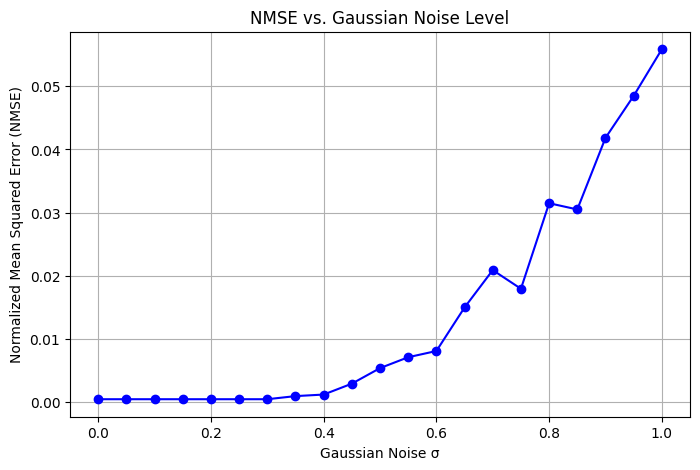

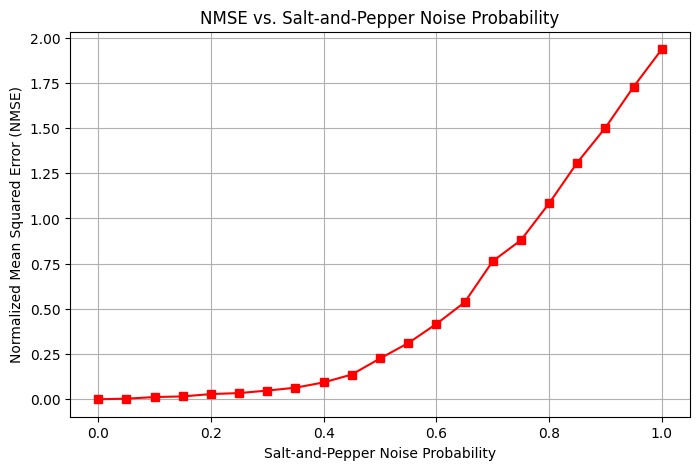

In [23]:
# Q4

def compute_nmse(denoised, ground_truth):
    mse = np.mean((denoised - ground_truth) ** 2)
    norm = np.mean(ground_truth ** 2)
    nmse = mse / norm
    return nmse

h = 0.5
beta = 1.0
eta = 1.0

# Define noise levels for Gaussian noise
#gaussian_sigmas = [0.5, 1, 2, 3, 5]
gaussian_sigmas = np.linspace(0.0, 1.0, 21)

# Initialize lists to store NMSE values
nmse_values_gaussian = []

# Iterate over each Gaussian noise level
for sigma in gaussian_sigmas:
    noisy_img = add_gaussian_noise(img, sigma)
    denoised_img, energies = icm_denoise(noisy_img, h, beta, eta, max_iter=50)

    nmse = compute_nmse(denoised_img, img)
    nmse_values_gaussian.append(nmse)

    #print(f"NMSE for σ={sigma}: {nmse:.4f}")

# Define noise levels for Salt-and-Pepper noise
#sap_probs = [0.05, 0.1, 0.15, 0.2, 0.25]
sap_probs = np.linspace(0.0, 1.0, 21)

# Initialize lists to store NMSE values
nmse_values_sap = []

# Iterate over each Salt-and-Pepper noise probability
for prob in sap_probs:
    noisy_img_sap = add_salt_and_pepper_noise(img, prob)
    denoised_img_sap, energies_sap = icm_denoise(noisy_img_sap, h, beta, eta, max_iter=50)

    nmse_sap = compute_nmse(denoised_img_sap, img)
    nmse_values_sap.append(nmse_sap)

    #print(f"NMSE for prob={prob}: {nmse_sap:.4f}")

# Plot NMSE vs Gaussian Noise Level
plt.figure(figsize=(8,5))
plt.plot(gaussian_sigmas, nmse_values_gaussian, marker='o', linestyle='-', color='b')
plt.title('NMSE vs. Gaussian Noise Level')
plt.xlabel('Gaussian Noise σ')
plt.ylabel('Normalized Mean Squared Error (NMSE)')
plt.grid(True)
plt.show()

# Plot NMSE vs. Salt-and-Pepper Noise Probability
plt.figure(figsize=(8,5))
plt.plot(sap_probs, nmse_values_sap, marker='s', linestyle='-', color='r')
plt.title('NMSE vs. Salt-and-Pepper Noise Probability')
plt.xlabel('Salt-and-Pepper Noise Probability')
plt.ylabel('Normalized Mean Squared Error (NMSE)')
plt.grid(True)
plt.show()

In [24]:
# Q7

# Define parameter ranges
h_values = np.arange(0.0, 1.1, 0.1)
beta_values = np.arange(0.0, 2.2, 0.2)
eta_values = np.arange(0.0, 2.2, 0.2)

# Initialize dictionaries to store NMSE results
nmse_results = {
    'h': {},
    'beta': {},
    'eta': {}
}

# Select fixed values for other parameters during each sweep
fixed_params = {
    'h': 0.5,
    'beta': 1.0,
    'eta': 1.0
}


# Vary h, fix beta and eta

for h in h_values:
    current_h = h
    current_beta = fixed_params['beta']
    current_eta = fixed_params['eta']

    noisy_img = add_salt_and_pepper_noise(img, 0.10)
    denoised_img, energies = icm_denoise(noisy_img, current_h, current_beta, current_eta, max_iter=50)

    nmse = compute_nmse(denoised_img, img)
    nmse_results['h'][h] = nmse

    print(f"h={h:.1f}: NMSE={nmse:.4f}")


# Vary beta, fix h and eta

for beta in beta_values:
    current_h = fixed_params['h']
    current_beta = beta
    current_eta = fixed_params['eta']

    noisy_img = add_salt_and_pepper_noise(img, 0.10)
    denoised_img, energies = icm_denoise(noisy_img, current_h, current_beta, current_eta, max_iter=50)

    nmse = compute_nmse(denoised_img, img)
    nmse_results['beta'][beta] = nmse

    print(f"beta={beta:.1f}: NMSE={nmse:.4f}")


# Vary eta, fix h and beta

for eta in eta_values:
    current_h = fixed_params['h']
    current_beta = fixed_params['beta']
    current_eta = eta

    noisy_img = add_salt_and_pepper_noise(img, 0.10)
    denoised_img, energies = icm_denoise(noisy_img, current_h, current_beta, current_eta, max_iter=50)

    nmse = compute_nmse(denoised_img, img)
    nmse_results['eta'][eta] = nmse

    print(f"eta={eta:.1f}: NMSE={nmse:.4f}")

h=0.0: NMSE=0.0121
h=0.1: NMSE=0.0091
h=0.2: NMSE=0.0101
h=0.3: NMSE=0.0094
h=0.4: NMSE=0.0098
h=0.5: NMSE=0.0089
h=0.6: NMSE=0.0098
h=0.7: NMSE=0.0081
h=0.8: NMSE=0.0113
h=0.9: NMSE=0.0079
h=1.0: NMSE=1.0536
Convergence achieved.
beta=0.0: NMSE=0.1946
Convergence achieved.
beta=0.2: NMSE=0.0822
beta=0.4: NMSE=0.0204
beta=0.6: NMSE=0.0224
beta=0.8: NMSE=0.0138
beta=1.0: NMSE=0.0111
beta=1.2: NMSE=0.0096
beta=1.4: NMSE=0.0084
beta=1.6: NMSE=0.0140
beta=1.8: NMSE=0.0094
beta=2.0: NMSE=0.0094
eta=0.0: NMSE=1.0094
eta=0.2: NMSE=1.0020
eta=0.4: NMSE=0.9936
eta=0.6: NMSE=0.0091
eta=0.8: NMSE=0.0111
eta=1.0: NMSE=0.0128
eta=1.2: NMSE=0.0106
eta=1.4: NMSE=0.0103
eta=1.6: NMSE=0.0221
eta=1.8: NMSE=0.0212
eta=2.0: NMSE=0.0236


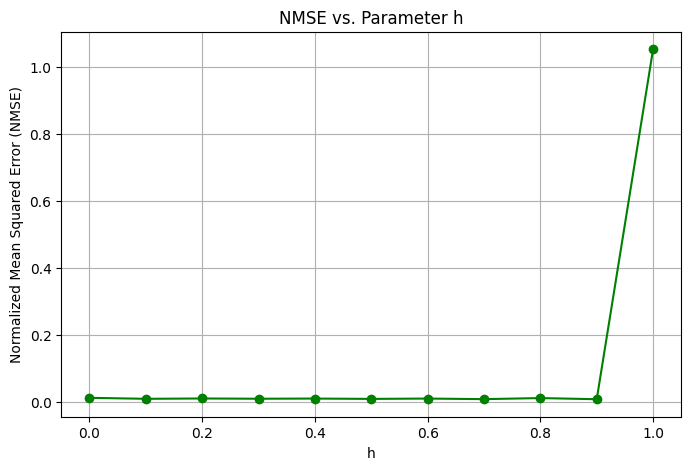

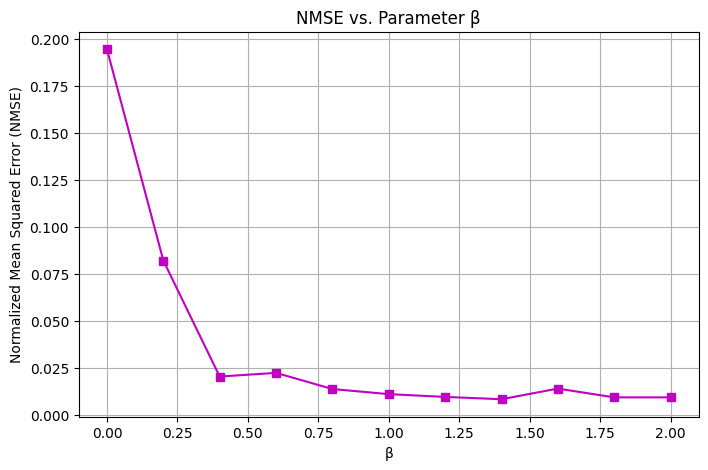

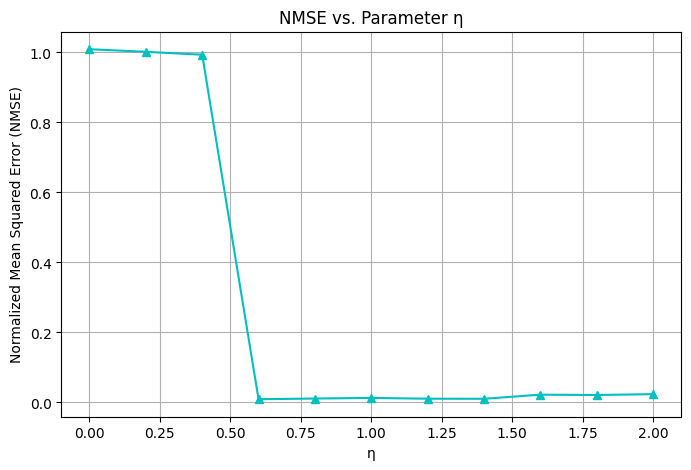

In [25]:
# Convert nmse_results to lists for plotting
h_vals = sorted(nmse_results['h'].keys())
h_nmse = [nmse_results['h'][h] for h in h_vals]

beta_vals = sorted(nmse_results['beta'].keys())
beta_nmse = [nmse_results['beta'][beta] for beta in beta_vals]

eta_vals = sorted(nmse_results['eta'].keys())
eta_nmse = [nmse_results['eta'][eta] for eta in eta_vals]

# Plot NMSE vs h
plt.figure(figsize=(8,5))
plt.plot(h_vals, h_nmse, marker='o', linestyle='-', color='g')
plt.title('NMSE vs. Parameter h')
plt.xlabel('h')
plt.ylabel('Normalized Mean Squared Error (NMSE)')
plt.grid(True)
plt.show()

# Plot NMSE vs beta
plt.figure(figsize=(8,5))
plt.plot(beta_vals, beta_nmse, marker='s', linestyle='-', color='m')
plt.title('NMSE vs. Parameter β')
plt.xlabel('β')
plt.ylabel('Normalized Mean Squared Error (NMSE)')
plt.grid(True)
plt.show()

# Plot NMSE vs eta
plt.figure(figsize=(8,5))
plt.plot(eta_vals, eta_nmse, marker='^', linestyle='-', color='c')
plt.title('NMSE vs. Parameter η')
plt.xlabel('η')
plt.ylabel('Normalized Mean Squared Error (NMSE)')
plt.grid(True)
plt.show()

In [26]:
import numpy as np

# Parameters
lambda_high = 10
lambda_low = 7
p_high_quality = 0.25
num_simulations = 100000

# Simulate the production process
high_quality_steel = np.random.rand(num_simulations) < p_high_quality

# Correctly handle the boolean mask
clips_produced = np.where(high_quality_steel,
                          np.random.poisson(lambda_high, num_simulations),
                          np.random.poisson(lambda_low, num_simulations))

pins_produced = np.where(high_quality_steel,
                         np.random.poisson(lambda_high, num_simulations),
                         np.random.poisson(lambda_low, num_simulations))

# Count the simulations where clips = 10 and pins = 8
mask = (clips_produced == 10) & (pins_produced == 8)
high_quality_count = np.sum(mask & high_quality_steel)

# Estimate the probability of high-quality steel
total_count = np.sum(mask)
probability_high_quality = high_quality_count / total_count if total_count > 0 else 0

print(f"Estimated probability of high-quality steel: {probability_high_quality:.4f}")

Estimated probability of high-quality steel: 0.3294
